In [ ]:
%%capture
!pip install numpy==1.26.4
!pip install ipywidgets vtk meshio pyvista Rtree

| Parameter    | Units                 | Physical Role                                        |
|--------------|-----------------------|------------------------------------------------------|
| $$ \mu $$    | $$\text{Pa}\cdot\text{s}$$ | Dynamic viscosity of blood                           |
| $$ k_t $$    | $$ \text{m}^2 $$      | 3D tissue permeability                               |
| $$ k_v $$    | $$ \text{m}^2 $$      | Axial permeability along the vessel                  |
| $$ \gamma $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Vessel wall permeability coefficient |
| $$ \gamma_R $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Boundary outflow permeability                 |
| $$ \gamma_a $$ | $$\text{m}$$                    | Terminal vessel hydraulic conductance at end |

Velocity units: $$\frac{\text{m}^2}{\text{Pa} \cdot s} \times \left(\frac{d(\text{Pa})}{d \text{m}}\right) = \frac{\text{m}}{\text{s}}$$

In [12]:
import sys, os
import numpy as np
from graphnics import FenicsGraph

WORK_PATH = "/root/3d-1d"
SOURCE_PATH = os.path.join(WORK_PATH, 'src')
sys.path.append(SOURCE_PATH)

import tissue, fem, visualize

TEST_GRAPH_NODES = {
    0: [0.01, 0.020, 0.020],
    1: [0.02, 0.020, 0.020],
    2: [0.03, 0.020, 0.020],
    3: [0.04, 0.020, 0.020]
}

TEST_GRAPH_EDGES = [
    (0, 1, 0.003),
    (1, 2, 0.003),
    (2, 3, 0.003)
]

TEST_GRAPH = FenicsGraph()

for node, pos in TEST_GRAPH_NODES.items():
    TEST_GRAPH.add_node(node, pos=pos)

for u, v, radius in TEST_GRAPH_EDGES:
    TEST_GRAPH.add_edge(u, v, radius=radius)

TEST_MESH_BUILD = tissue.MeshBuild(
    G = TEST_GRAPH,
    Omega_bounds = np.array([[0,0,0],[0.05, 0.04, 0.04]]),
    Omega_mesh_voxel_dim = (32, 20, 20)
)
TEST_SINK_FACE = TEST_MESH_BUILD.get_Omega_axis_plane("left")

TEST_MEASURE = tissue.MeasureBuild(
    mesh_build = TEST_MESH_BUILD,
    Lambda_inlet = [0],
    Omega_sink = TEST_SINK_FACE
)

_pos = np.array(TEST_GRAPH.nodes[3]['pos'])
_offset = np.array([0.01, 0.01, 0.01])
_upper_cube_bounds_val = [_pos - _offset, _pos + _offset]

CUBES_TEST = fem.SubCubes(
    domain = TEST_MEASURE,
    gamma = 1.0e-3,
    gamma_R = 1.0e-5,
    gamma_a = 1.0e-11,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.2e-8, # Vessel permeability in 1D
    P_in = 100 * 133.322,
    p_cvp = 1.0 * 133.322,
    lower_cube_bounds = [[0.001, 0, 0],[0.002, 0.04, 0.04]],
    upper_cube_bounds = _upper_cube_bounds_val
)

print(f"Sink Outflow (m^3/s): {CUBES_TEST.compute_outflow_sink()}")
print(f"Total Outflow (m^3/s): {CUBES_TEST.compute_outflow_all()}")
print(f"Net flux through lower: {CUBES_TEST.compute_lower_cube_flux()}")

print(f"Inflow through lower: {CUBES_TEST.compute_lower_cube_flux_in()}")
print(f"Outflow through lower: {CUBES_TEST.compute_lower_cube_flux_out()}")
print(f"Inflow through upper: {CUBES_TEST.compute_upper_cube_flux_in()}")
print(f"Outflow through upper: {CUBES_TEST.compute_upper_cube_flux_out()}")

Averaging over 96 cells: 100%|██████████| 96/96 [00:00<00:00, 2682.98it/s]


Sink Outflow (m^3/s): -4.8976002764049555e-05
Total Outflow (m^3/s): -5.154939558229185e-05
Net flux through lower: -2.573175523045958e-06
Inflow through lower: -2.577975666723355e-06
Outflow through lower: 4.8001436773970965e-09
Inflow through upper: -1.7342296797331058e-08
Outflow through upper: 1.7125001601021025e-08


Node Pressure Data:
Node 0: Pressure 13332.2
Node 49: Pressure 13229.0
Node 25: Pressure 13131.7
Node 50: Pressure 13038.1
Node 13: Pressure 12946.6
Node 52: Pressure 12856.6
Node 26: Pressure 12768.1
Node 51: Pressure 12681.0
Node 7: Pressure 12595.2
Node 55: Pressure 12510.3
Node 28: Pressure 12426.4
Node 56: Pressure 12343.4
Node 14: Pressure 12261.4
Node 54: Pressure 12180.3
Node 27: Pressure 12100.0
Node 53: Pressure 12020.4
Node 4: Pressure 11941.6
Node 61: Pressure 11863.6
Node 31: Pressure 11786.3
Node 62: Pressure 11709.7
Node 16: Pressure 11633.8
Node 64: Pressure 11558.5
Node 32: Pressure 11483.8
Node 63: Pressure 11409.8
Node 8: Pressure 11336.3
Node 59: Pressure 11263.4
Node 30: Pressure 11191.1
Node 60: Pressure 11119.3
Node 15: Pressure 11048.0
Node 58: Pressure 10977.3
Node 29: Pressure 10907.0
Node 57: Pressure 10837.3
Node 1: Pressure 10767.9
Node 65: Pressure 10699.1
Node 33: Pressure 10630.7
Node 66: Pressure 10562.7
Node 17: Pressure 10495.1
Node 68: Pressure 10428

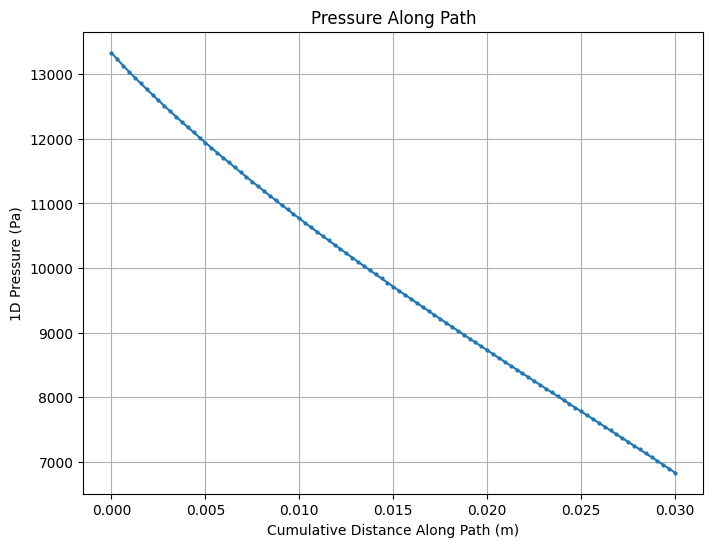

In [13]:
fig1 = visualize.plot_path_pressure(CUBES_TEST.uh1d, TEST_GRAPH, [0, 1, 2, 3])
fig1.show()

Lower Cube Bounds: [[0.001, 0, 0], [0.002, 0.04, 0.04]]
Upper Cube Bounds: [array([0.03, 0.01, 0.01]), array([0.05, 0.03, 0.03])]


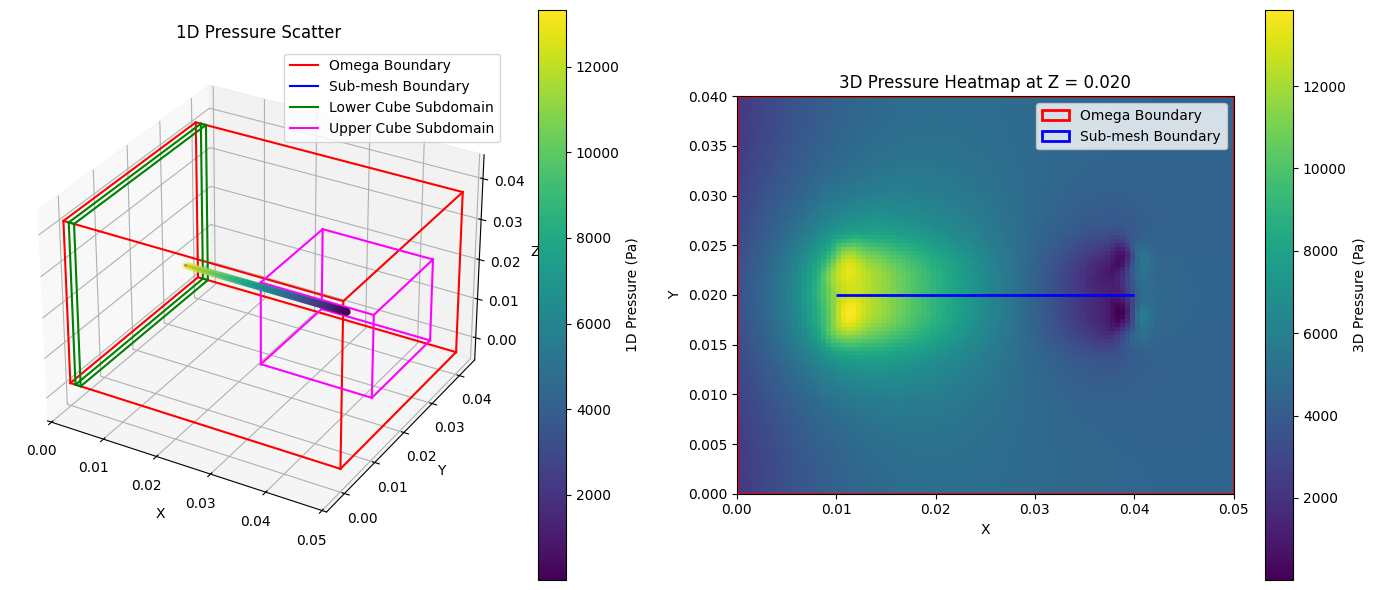

In [6]:
cube_lower_bounds = CUBES_TEST.lower_cube_bounds
cube_upper_bounds = CUBES_TEST.upper_cube_bounds

print("Lower Cube Bounds:", cube_lower_bounds)
print("Upper Cube Bounds:", cube_upper_bounds)

fig1 = visualize.plot_with_boundaries(CUBES_TEST.uh1d, CUBES_TEST.uh3d,
     cube_lower=cube_lower_bounds, 
     cube_upper=cube_upper_bounds)
fig1.show()

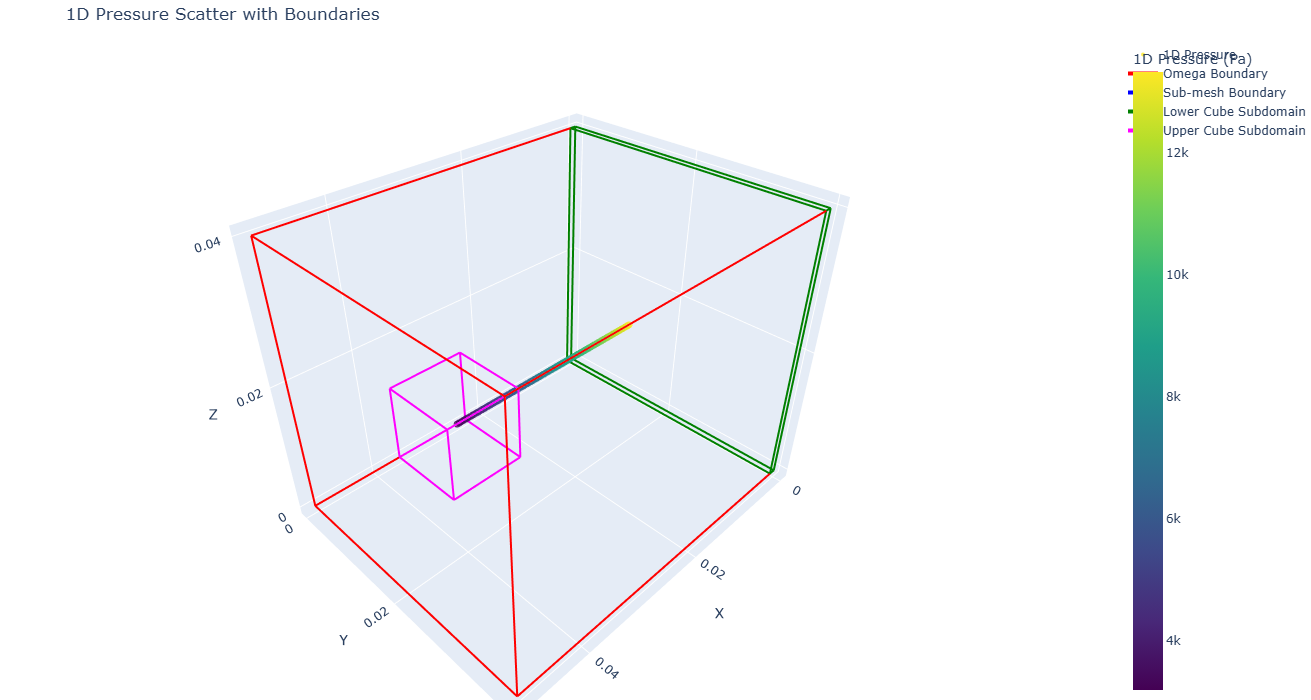

In [34]:
visualize.plot_with_boundaries_plotly(CUBES_TEST.uh1d, CUBES_TEST.uh3d,
     cube_lower=cube_lower_bounds, 
     cube_upper=cube_upper_bounds)

In [10]:
import datetime
import pytz

cst = pytz.timezone("America/Chicago")
now = datetime.datetime.now(cst)
timestamp = now.strftime("%Y%m%d_%H%M")
filename = f"straightline_output_{timestamp}"

SAVE_PATH = os.path.join(WORK_PATH, "export", filename)
CUBES_TEST.save_vtk(SAVE_PATH)